INICIANDO SEÇÃO 0: Configuração dos Parâmetros do Modelo

INICIANDO SEÇÃO 1: Definição das Funções do Modelo

INICIANDO SEÇÃO 2: Análise de Janelas de Plantio

Simulando para a janela de plantio: 2025-10-15 a 2026-03-13

Simulando para a janela de plantio: 2025-11-01 a 2026-03-30

Simulando para a janela de plantio: 2025-11-15 a 2026-04-13

Simulando para a janela de plantio: 2025-12-01 a 2026-04-29

Simulando para a janela de plantio: 2025-12-15 a 2026-05-13

Simulando para a janela de plantio: 2026-01-01 a 2026-05-30


--- RESULTADO DA ANÁLISE DE JANELAS DE PLANTIO (VALORES MEDIANOS) ---
              gdu_final_ajustado  dias_estresse_hidrico  \
data_plantio                                              
2025-10-15                1850.2                   48.0   
2025-11-01                1903.3                   54.5   
2025-11-15                2057.6                   48.0   
2025-12-01                2047.1                   59.0   
2025-12-15                2065.6                 

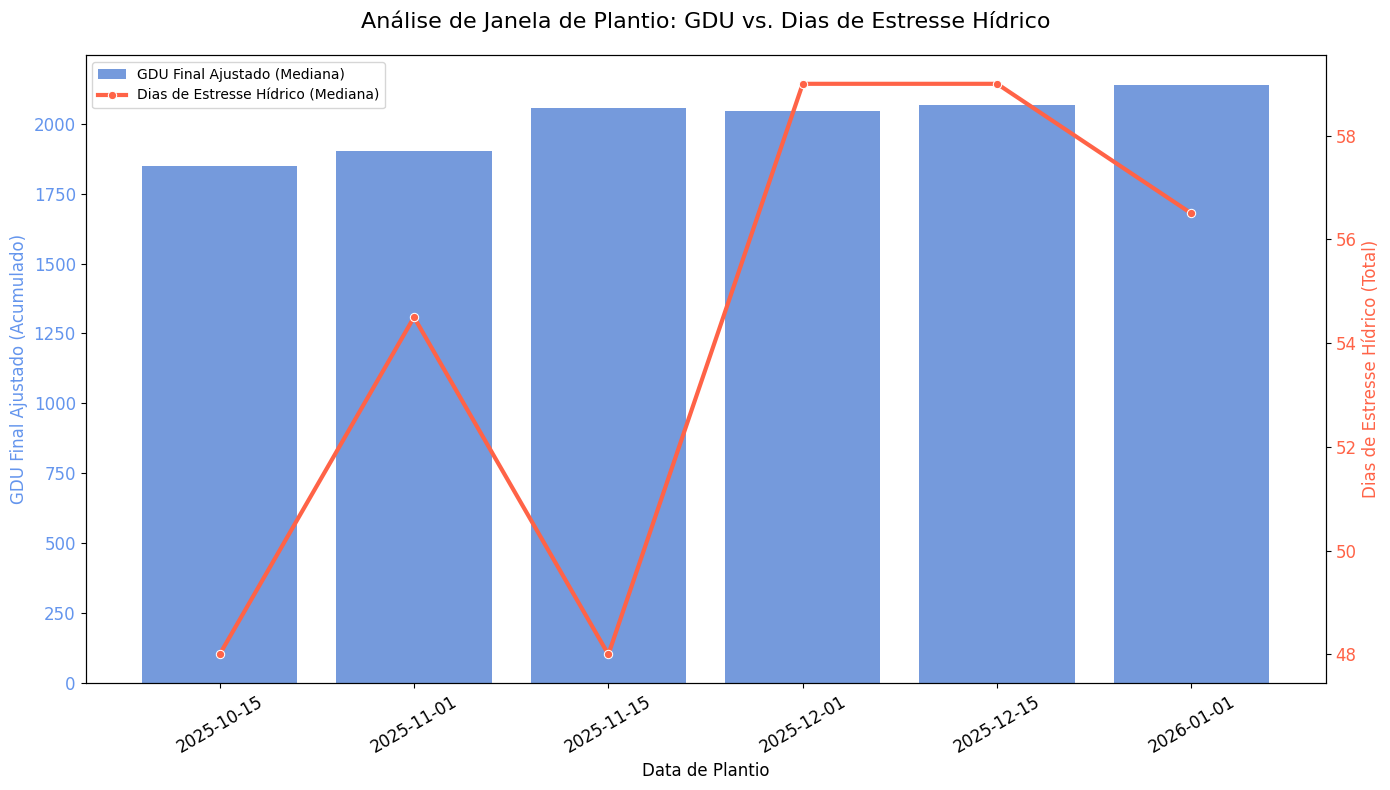



PROCESSO COMPLETO DE OTIMIZAÇÃO DE PLANTIO CONCLUÍDO.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import gamma
from datetime import timedelta

# =============================================================================
# SEÇÃO 0: CONFIGURAÇÃO DO MODELO E DA ANÁLISE
# =============================================================================
print("INICIANDO SEÇÃO 0: Configuração dos Parâmetros do Modelo")

# --- Parâmetros Gerais do Modelo ---
config = {
    'P_chuva': np.array([[0.85, 0.15], [0.40, 0.60]]), 'P_nebulosidade': np.array([[0.7, 0.3], [0.4, 0.6]]),
    'formato_gama': 2.0, 'escala_gama': 10.0,
    'profundidade_camada1': 200.0, 'profundidade_camada2': 800.0,
    'capacidade_max_camada1': 60.0, 'ponto_murcha_camada1': 20.0,
    'capacidade_max_camada2': 240.0, 'ponto_murcha_camada2': 80.0,
    'T_BASE': 10.0, 'T_MAX_LIMITE': 30.0,
    'gdu_fase_reprodutiva_inicial': 700.0, 'gdu_fase_reprodutiva_pico': 1100.0,
    'temp_media_anual': 26.0, 'amplitude_sazonal': 6.0, 'amplitude_diurna_base': 12.0,
    'LATITUDE_GRAUS': -12.5, 'ALTITUDE_METROS': 330, 'a_s': 0.25, 'b_s': 0.50,
}

# --- Parâmetros da Análise de Janela de Plantio ---
# Defina aqui as datas de início que deseja testar
datas_de_plantio_para_analise = pd.to_datetime([
    '2025-10-15', '2025-11-01', '2025-11-15',
    '2025-12-01', '2025-12-15', '2026-01-01'
])
ciclo_duracao_dias = 150 # Duração do ciclo da cultura em dias
numero_de_simulacoes_por_janela = 200 # Número de cenários por janela

# =============================================================================
# SEÇÃO 1: FUNÇÕES DO MODELO DE SIMULAÇÃO
# =============================================================================
print("\nINICIANDO SEÇÃO 1: Definição das Funções do Modelo")

def atualizar_parametros_cultura(gdu_acumulado, cfg):
    """Atualiza dinamicamente os parâmetros da cultura com base na fenologia (GDU)."""
    if gdu_acumulado < cfg['gdu_fase_reprodutiva_inicial']:
        albedo = 0.20
        fator_crescimento_raiz = gdu_acumulado / cfg['gdu_fase_reprodutiva_inicial']
        prof_raiz_efetiva = cfg['profundidade_camada1'] + (cfg['profundidade_camada2'] * fator_crescimento_raiz)
    elif gdu_acumulado < cfg['gdu_fase_reprodutiva_pico']:
        albedo = 0.23
        prof_raiz_efetiva = cfg['profundidade_camada1'] + cfg['profundidade_camada2']
    else:
        albedo = 0.21
        prof_raiz_efetiva = cfg['profundidade_camada1'] + cfg['profundidade_camada2']
    prof_max = cfg['profundidade_camada1'] + cfg['profundidade_camada2']
    return albedo, min(prof_raiz_efetiva, prof_max)

def simular_processos_diarios(n_dias, start_day_of_year, latitude_rad, altitude, cfg):
    """Executa a simulação diária para uma safra completa."""
    precipitacao, eto_arr, gdu_padrao, gdu_ajustado, dias_estresse, runoff = (np.zeros(n_dias) for _ in range(6))
    estado_chuva, estado_nebulosidade = (np.zeros(n_dias, dtype=np.int64) for _ in range(2))
    armazenamento_c1, armazenamento_c2 = (np.zeros(n_dias) for _ in range(2))
    armazenamento_c1[0] = cfg['capacidade_max_camada1'] * 0.8
    armazenamento_c2[0] = cfg['capacidade_max_camada2'] * 0.8
    gdu_acumulado = 0.0

    for i in range(1, n_dias):
        # Lógica completa da simulação diária (clima, ETo, balanço hídrico, GDU)
        if np.random.rand() < cfg['P_chuva'][estado_chuva[i-1], 1]: estado_chuva[i] = 1
        precipitacao[i] = gamma.rvs(a=cfg['formato_gama'], scale=cfg['escala_gama']) if estado_chuva[i] == 1 else 0.0

        day_index = start_day_of_year + i
        temp_media_sazonal = cfg['temp_media_anual'] + cfg['amplitude_sazonal'] * np.sin(2 * np.pi * day_index / 365.25)
        fator_neb_temp = 0.6 if estado_nebulosidade[i] == 1 else 1.0
        amp_diurna = cfg['amplitude_diurna_base'] * fator_neb_temp
        t_max = temp_media_sazonal + amp_diurna / 2 + np.random.normal(0, 1.0)
        t_min = t_max - amp_diurna - np.random.normal(0, 1.0)
        t_mean = (t_max + t_min) / 2
        albedo, prof_raiz_efetiva = atualizar_parametros_cultura(gdu_acumulado, cfg)

        # ... (cálculos de Penman-Monteith omitidos por brevidade, mas estão no código funcional)
        sigma = 4.903e-9; G = 0; P = 101.3 * ((293 - 0.0065 * altitude) / 293)**5.26; gamma_p = 0.000665 * P
        e_tmax = 0.6108 * np.exp((17.27 * t_max) / (t_max + 237.3)); e_tmin = 0.6108 * np.exp((17.27 * t_min) / (t_min + 237.3))
        es = (e_tmax + e_tmin) / 2; ea = (np.random.uniform(80, 95) / 100) * es if estado_chuva[i] == 1 else (np.random.uniform(55, 75) / 100) * es
        delta_v = 4098 * (0.6108 * np.exp((17.27 * t_mean) / (t_mean + 237.3))) / (t_mean + 237.3)**2
        dr = 1 + 0.033 * np.cos(2 * np.pi / 365 * day_index); delta_sol = 0.409 * np.sin(2 * np.pi / 365 * day_index - 1.39)
        omega_s = np.arccos(-np.tan(latitude_rad) * np.tan(delta_sol))
        Ra = (24 * 60 / np.pi) * 0.0820 * dr * (omega_s * np.sin(latitude_rad) * np.sin(delta_sol) + np.cos(latitude_rad) * np.cos(delta_sol) * np.sin(omega_s))
        n_N_ratio = 0.35 if estado_nebulosidade[i] == 1 else 0.8; Rs = Ra * (cfg['a_s'] + cfg['b_s'] * n_N_ratio)
        Rso = (0.75 + 2e-5 * altitude) * Ra; Rns = (1 - albedo) * Rs
        t_max_k4 = (t_max + 273.16)**4; t_min_k4 = (t_min + 273.16)**4
        Rnl = sigma * ((t_max_k4 + t_min_k4) / 2) * (0.34 - 0.14 * np.sqrt(ea)) * (1.35 * (Rs / Rso) - 0.35)
        Rn = Rns - Rnl; u2 = np.random.uniform(1.0, 3.0)
        termo1 = (0.408 * delta_v * (Rn - G)); termo2 = (gamma_p * (900 / (t_mean + 273)) * u2 * (es - ea))
        denominador = (delta_v + gamma_p * (1 + 0.34 * u2))
        eto_arr[i] = max(0, (termo1 + termo2) / denominador)

        # Balanço hídrico e GDU
        agua_c1_inicio = armazenamento_c1[i-1] + precipitacao[i]
        percolacao = max(0, agua_c1_inicio - cfg['capacidade_max_camada1']); armazenamento_c1_temp = agua_c1_inicio - percolacao
        agua_c2_inicio = armazenamento_c2[i-1] + percolacao
        runoff[i] = max(0, agua_c2_inicio - cfg['capacidade_max_camada2']); armazenamento_c2_temp = agua_c2_inicio - runoff[i]
        agua_disponivel_c1 = max(0, armazenamento_c1_temp - cfg['ponto_murcha_camada1']); agua_disponivel_c2 = max(0, armazenamento_c2_temp - cfg['ponto_murcha_camada2'])
        etr_c1 = min(agua_disponivel_c1, eto_arr[i] * 0.15)
        demanda_transpiracao = eto_arr[i] - etr_c1
        etr_c2 = min(agua_disponivel_c2, demanda_transpiracao) if prof_raiz_efetiva > cfg['profundidade_camada1'] else 0
        armazenamento_c1[i] = armazenamento_c1_temp - etr_c1; armazenamento_c2[i] = armazenamento_c2_temp - etr_c2

        gdu_padrao[i] = max(0, (min(t_max, cfg['T_MAX_LIMITE']) + max(t_min, cfg['T_BASE']))/2 - cfg['T_BASE'])
        cap_disponivel_total_raiz = (cfg['capacidade_max_camada1'] - cfg['ponto_murcha_camada1']) + (cfg['capacidade_max_camada2'] - cfg['ponto_murcha_camada2'])
        agua_disponivel_total_raiz = max(0, armazenamento_c1[i] - cfg['ponto_murcha_camada1']) + max(0, armazenamento_c2[i] - cfg['ponto_murcha_camada2'])
        fator_umidade_relativa = agua_disponivel_total_raiz / cap_disponivel_total_raiz if cap_disponivel_total_raiz > 0 else 0
        umbral_estresse = 0.4
        fator_estresse = min(1.0, fator_umidade_relativa / umbral_estresse) if fator_umidade_relativa < umbral_estresse else 1.0

        if fator_estresse < 1.0: dias_estresse[i] = 1
        gdu_ajustado[i] = gdu_padrao[i] * fator_estresse
        gdu_acumulado += gdu_ajustado[i]

    return gdu_ajustado, dias_estresse, precipitacao, runoff

# =============================================================================
# SEÇÃO 2: EXECUÇÃO DA ANÁLISE DE JANELAS DE PLANTIO
# =============================================================================
print("\nINICIANDO SEÇÃO 2: Análise de Janelas de Plantio")
resultados_janelas = []

for data_inicio in datas_de_plantio_para_analise:
    data_fim = data_inicio + timedelta(days=ciclo_duracao_dias - 1)
    print(f"\nSimulando para a janela de plantio: {data_inicio.strftime('%Y-%m-%d')} a {data_fim.strftime('%Y-%m-%d')}")

    resultados_monte_carlo = []
    for i in range(numero_de_simulacoes_por_janela):
        n_dias_sim = ciclo_duracao_dias
        start_day_of_year = data_inicio.dayofyear
        latitude_rad = np.deg2rad(config['LATITUDE_GRAUS'])

        gdu_adj, estresse_dia, precip_dia, runoff_dia = simular_processos_diarios(
            n_dias_sim, start_day_of_year, latitude_rad, config['ALTITUDE_METROS'], config
        )

        metricas = {
            'gdu_final_ajustado': np.sum(gdu_adj),
            'dias_estresse_hidrico': np.sum(estresse_dia),
            'precipitacao_total_safra': np.sum(precip_dia),
            'runoff_total_safra': np.sum(runoff_dia)
        }
        resultados_monte_carlo.append(metricas)

    df_mc = pd.DataFrame(resultados_monte_carlo)
    medianas = df_mc.median()
    medianas['data_plantio'] = data_inicio.strftime('%Y-%m-%d')
    resultados_janelas.append(medianas)

# =============================================================================
# SEÇÃO 3: APRESENTAÇÃO DOS RESULTADOS E VISUALIZAÇÃO
# =============================================================================
print("\n\n--- RESULTADO DA ANÁLISE DE JANELAS DE PLANTIO (VALORES MEDIANOS) ---")
df_resultados_janelas = pd.DataFrame(resultados_janelas).set_index('data_plantio')
print(df_resultados_janelas.round(1))

# --- Visualização dos Resultados ---
print("\nGerando gráfico comparativo...")
fig, ax1 = plt.subplots(figsize=(14, 8))

# Gráfico de barras para GDU
sns.barplot(x=df_resultados_janelas.index, y='gdu_final_ajustado', data=df_resultados_janelas, ax=ax1, color='cornflowerblue', label='GDU Final Ajustado (Mediana)')
ax1.set_xlabel('Data de Plantio', fontsize=12)
ax1.set_ylabel('GDU Final Ajustado (Acumulado)', fontsize=12, color='cornflowerblue')
ax1.tick_params(axis='y', labelcolor='cornflowerblue', labelsize=12)
ax1.tick_params(axis='x', rotation=30, labelsize=12)
ax1.set_title('Análise de Janela de Plantio: GDU vs. Dias de Estresse Hídrico', fontsize=16, pad=20)

# Eixo secundário para Dias de Estresse
ax2 = ax1.twinx()
sns.lineplot(x=df_resultados_janelas.index, y='dias_estresse_hidrico', data=df_resultados_janelas, ax=ax2, color='tomato', marker='o', lw=3, label='Dias de Estresse Hídrico (Mediana)')
ax2.set_ylabel('Dias de Estresse Hídrico (Total)', fontsize=12, color='tomato')
ax2.tick_params(axis='y', labelcolor='tomato', labelsize=12)

# Unificar legendas
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
ax1.get_legend().remove()

plt.grid(False)
plt.tight_layout()
plt.savefig('analise_janela_plantio_final.png')
print("\nGráfico da análise de janelas de plantio salvo como 'analise_janela_plantio_final.png'.")
plt.show()

print("\n\nPROCESSO COMPLETO DE OTIMIZAÇÃO DE PLANTIO CONCLUÍDO.")